# The Black-Scholes PDE

[*Black Scholes PDE, WIKI*](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_equation). 

In this notebook I want to show how to solve the famous Black-Scholes (BS) Partial Differential Equation (PDE).

\begin{equation}
\frac{\partial  V(t,s)}{\partial t}  
          + r\,s \frac{\partial V(t,s)}{\partial s}
          + \frac{1}{2} \sigma^2 s^2 \frac{\partial^2  V(t,s)}{\partial s^2} - r  V(t,s)  = 0.
\end{equation}

I decided to use a fully implicit method, because it is an efficient and stable method. The illustrated approach can be used to solve more complex problems, such as the pricing of different types of derivatives (barrier options, digital options, American options, etc) with small modifications.

## Contents
   - [The BS PDE](#sec1)
      - [PDE in log-variables](#sec1.1)
      - [Implicit discretization](#sec1.2)
   - [Introduction to sparse matrices](#sec2)
   - [Numerical solution of the PDE](#sec3)

In [2]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
%matplotlib inline


from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

from IPython.display import display
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))

<a id='sec1'></a>
## The BS PDE

Ok ok... *Nihil novi sub sole*. The PDE derivation can be found in every textbooks... I know.  

I suggest the interested reader to have a look at [1] for a clear exposition. If you are already familiar with these concepts, maybe it can be interesting for you to have a look at the notebook **A3**, where I present the derivation of the P(I)DE for general exponential Lévy processes. The BS PDE appears as a special case.

<a id='sec1.1'></a>
## PDE in log-variables

Let us consider the geometric Brownian motion (GBM), described by the SDE:    

\begin{equation}
	  \frac{dS_t}{S_t} = \mu dt + \sigma dW_t.
\end{equation}

Let $V(t,s)$ be the value of a European call option. 

By the **martingale pricing theory**, in an arbitrage-free market there exists an equivalent martingale measure $\mathbb{Q}$ such that the discounted option price is a $\mathbb{Q}$-martingale. (Remember that under $\mathbb{Q}$ the drift $\mu$ is replaced by the risk free drift $r$.)

The PDE for the option price is:

\begin{equation}
 \frac{\partial V(t,s)}{\partial t} + \mathcal{L}^{S} V(t,s) -r V(t,s) = 0   
\end{equation}

where $\mathcal{L}^{S}$ is the infinitesimal generator of $\{S_t\}_{t\in[t_0,T]}$.  
In the Black-Scholes model, the measure $\mathbb{Q}$ is unique and the infinitesimal generator under this measure is:

\begin{equation}
 \mathcal{L}^{BS} V(t,s) = \;  r s \frac{\partial V(t,s)}{\partial s}
+ \frac{1}{2} \sigma^2 s^2 \frac{\partial^2  V(t,s)}{\partial s^2},
\end{equation}

In order to simplify the computations, it is better to pass to the log-variable $x = \log s$. This change corresponds to the following change in the operators:

\begin{equation}
s \frac{\partial}{\partial s} = \frac{\partial}{\partial x}, \hspace{2em} 
s^2 \frac{\partial^2}{\partial s^2} = \frac{\partial^2}{\partial x^2} - \frac{\partial}{\partial x} . 
\end{equation}

In log-variables the BS PDE is:

$$ \frac{\partial  V(t,x)}{\partial t}  
          + \biggl( r -\frac{1}{2}\sigma^2 \biggr) \frac{\partial V(t,x)}{\partial x}
          + \frac{1}{2} \sigma^2 \frac{\partial^2  V(t,x)}{\partial x^2} - r  V(t,x)  = 0. $$

For an option with strike $K$ and maturity $T$, the boundary conditions are:

CALL:
 - Terminal:
 $$ V(T,x) = \max(e^x-K,0), $$
 - Lateral:
 $$ V(t, x) \underset{x \to -\infty}{=} 0 \quad \mbox{and} \quad V(t, x) \underset{x \to \infty}{\sim} e^x - Ke^{-r(T-t)}. $$

PUT:
 - Terminal:
 $$ V(T,x) = \max(K-e^x,0), $$
 - Lateral:
  $$ V(t, x) \underset{x \to -\infty}{\sim} Ke^{-r(T-t)} \quad \mbox{and} \quad V(t, x) \underset{x \to \infty}{=} 0. $$

## Derivative approximation

Finite difference methods are a technique for obtaining numerical solutions of PDEs. 
The idea underlying finite-difference methods is to replace the partial derivatives occurring in the PDE by finite difference approximations. If we assume that $V$ is a smooth function, we can use the Taylor series expansion near the point of interest.
For a $\Delta t > 0$ we can write

\begin{equation}
 V(t+\Delta t,x) \approx V(t,x) + \frac{\partial V(t,x)}{\partial t} \Delta t + \frac{1}{2} \frac{\partial^2 V(t,x)}{\partial t^2} \Delta t^2 + \mathcal{O}(\Delta t^3).
\end{equation}
\begin{equation}
 V(t-\Delta t,x) \approx V(t,x) - \frac{\partial V(t,x)}{\partial t} \Delta t + \frac{1}{2} \frac{\partial^2 V(t,x)}{\partial t^2} \Delta t^2 + \mathcal{O}(\Delta t^3).
\end{equation}

An analogous approximation can be done for $V(t,x+\Delta x)$ with $\Delta x > 0$.

If we want to approximate the partial derivative with respect to time, we obtain the following finite difference approximation

\begin{equation}
 \frac{\partial V(t,x)}{\partial t} \approx \frac{V(t+\Delta t,x) - V(t,x)}{\Delta t} + \mathcal{O}(\Delta t)
\end{equation}

also called **forward difference**, since the differencing is in the forward $t$ direction.
We can also consider the **backward difference**

\begin{equation}
 \frac{\partial V(t,x)}{\partial t} \approx \frac{V(t,x) - V(t-\Delta t,x)}{\Delta t} + \mathcal{O}(\Delta t)
\end{equation}

and the **central difference**

\begin{equation}
 \frac{\partial V(t,x)}{\partial t} \approx \frac{V(t+\Delta t,x) - V(t-\Delta t,x)}{2 \Delta t} + \mathcal{O}(\Delta t^2).
\end{equation}

The use of the forward and backward difference approximation leads to the **explicit** and **implicit** finite difference 
schemes respectively. The central difference is not used for the time variable because it leads to bad numerical schemes.
But it is common to use it for the space variable.

For second order derivatives, such as $\partial^2 V(t,x)/\partial x^2$, we can use the symmetric central difference approximation for a $\Delta x > 0$:

\begin{equation}
 \frac{\partial^2 V(t,x)}{\partial x^2} \approx \frac{V(t,x+\Delta x) + V(t,x-\Delta x) - 2V(t,x)}{ \Delta x^2} + \mathcal{O}(\Delta x^2).
\end{equation}

If you need more details, have a look at [2].

<a id='sec1.2'></a>
## Implicit discretization


First we have to restrict the theoretical infinite domain to the finite region $[t_0,T]\, \times \, [A_1,A_2]$, with $A_1 < A_2$. 

The next step is to replace $[t_0,T]\times [A_1,A_2]$ by a discrete grid:

For $n = 0,1, ... N \in \mathbb{N}$, define the discrete time step $ \Delta t = \frac{T - t_0}{N} $ such that
$t_n = t_0 + n \Delta t$. For $i = 0,1, ... M \in \mathbb{N}$, define the discrete space step $ \Delta x = \frac{A_2 - A_1}{M} $ such that
$x_i = A_1 + i \Delta x$.

The grid is divided into equally spaced nodes of distance $\Delta x$ in the x-axis, and of distance $\Delta t$ in the t-axis.

The mesh points have the form $(t_0 + n \Delta t, A_1 + i \Delta x)$.
At this point we concern ourselves only with the values of $V(t,x)$ on the mesh nodes. We call 

$$ V(t_0 + n \Delta t, A_1 + i \Delta x) = V^n_i .$$

We apply the backward discretization (implicit scheme) for the time derivative, and a central discretization for the first order space derivative.  

We are interested in the value of V at time $t_0$. We know the values $V^N$ corresponding to the terminal conditions. The algorithm consists in finding the values $V^n$ given the knowledge of the values $V^{n+1}$. 

**Comment:**
 A common practice is to invert the time flow i.e. introducing a new time variable $\tau = -t$ and change the variables in the PDE. It follows that the terminal conditions become initial conditions, and the problem becomes a forward problem. However, I am not using this change of variable in this notebook.

The discretized equation becomes

$$ \begin{aligned}
\frac{V^{n+1}_{i} -V^{n}_{i}}{\Delta t} + 
(r-\frac{1}{2}\sigma^2) \frac{V^{n}_{i+1} -V^{n}_{i-1}}{ 2 \Delta x}
+ \frac{1}{2} \sigma^2 \frac{V^{n}_{i+1} + V^{n}_{i-1} - 2 V^{n}_{i}}{\Delta x^2}  - r V^{n}_i = 0.
\end{aligned}$$

Rearranging the terms: 

$$ \begin{aligned}
 V^{n+1}_{i} &= V^{n}_{i} \biggl( 1 + r\Delta t + \sigma^2 \frac{\Delta t}{\Delta x^2} \biggr)  \\
& + V^{n}_{i+1} \biggl( -(r -\frac{1}{2}\sigma^2)\frac{\Delta t}{2 \Delta x} -
\frac{1}{2}\sigma^2 \frac{\Delta t}{\Delta x^2}  \biggr)  \\
& + V^{n}_{i-1} \biggl( (r -\frac{1}{2}\sigma^2)\frac{\Delta t}{2 \Delta x} - 
\frac{1}{2}\sigma^2 \frac{\Delta t}{\Delta x^2}  \biggr).
\end{aligned} $$

We can rename the coefficients such that:   

$$ V^{n+1}_{i} = a V^{n}_{i-1} + b V^{n}_{i} + c V^{n}_{i+1}, $$

and write it in matrix form:

$$
\left(
\begin{array}{c}
V^{n+1}_{1} \\
V^{n+1}_{2} \\
\vdots \\
V^{n+1}_{M-2} \\
V^{n+1}_{M-1} \\
\end{array}
\right) = 
\underbrace{
\left(
\begin{array}{ccccc}
b     & c  & 0 & \cdots  & 0 \\
a     & b  & c & 0  & 0  \\
0      & \ddots & \ddots &   \ddots     & 0  \\
\vdots & 0 & a & b  & c  \\
0      & 0 & 0 & a  & b \\
\end{array}
\right) }_{\mathcal{D}} \cdot
\left(
\begin{array}{c}
V^{n}_{1} \\
V^{n}_{2} \\
\vdots \\
V^{n}_{M-2} \\
V^{n}_{M-1} 
\end{array}
\right)
+ \underbrace{
\left(
\begin{array}{c}
 a V^{n}_{0} \\
  0 \\
 \vdots \\
 0 \\
c V^{n}_{M} \\
\end{array}
\right) }_{\mbox{B (boundary terms)}}
$$

The system 

$$ V^{n+1} = \mathcal{D} V^{n} + B $$

can be solved easily for $V^{n}$ by inverting the matrix $\mathcal{D}$.


<a id='sec2'></a>
## Introduction to sparse matrices 

A [*sparse matrix*](https://en.wikipedia.org/wiki/Sparse_matrix) is a matrix in which most of the entries are zeros.

If most of the elements are nonzero, then the matrix is considered *dense*.

A dense matrix is typically stored as a two-dimensional array. Each entry in the array represents an element of the matrix and is accessed by the two indices i and j.

Since a sparse matrix is almost empthy, storing all the zeros is a waste of memory. For this reason it is more efficient to use different data structures from the usual 2D arrays. More information on these can be found in the wiki page. 

Have a look at the manual page of the **scipy.sparse** library. [link](https://docs.scipy.org/doc/scipy/reference/sparse.html).

There are many ways to represent a sparse matrix, Scipy provides seven of them:
- Block Sparse Row (BSR)
- Coordinate list (COO)
- Compressed Sparse Column (CSC)
- Compressed Sparse Row (CSR)
- DIAgonal storage (DIA)
- Dictionary Of Keys (DOK)
- List of lists (LIL)

Each format has its pros and cons. But we can roughly divide them in two groups: 
- CSR and CSC are better for efficient matrix operations.
- All the others are better for the initial construction the sparse matrix.

The good thing is that it is very easy to convert one representation into one other. Here I pasted some recomandations from the scipy manual page:

*To construct a matrix efficiently, use either dok_matrix or lil_matrix. The lil_matrix class supports basic slicing and fancy indexing with a similar syntax to NumPy arrays. The COO format may also be used to efficiently construct matrices. Despite their similarity to NumPy arrays, it is strongly discouraged to use NumPy functions directly on these matrices because NumPy may not properly convert them for computations, leading to unexpected (and incorrect) results. If you do want to apply a NumPy function to these matrices, first check if SciPy has its own implementation for the given sparse matrix class, or convert the sparse matrix to a NumPy array (e.g. using the toarray() method of the class) first before applying the method.
To perform manipulations such as multiplication or inversion, first convert the matrix to either CSC or CSR format. The lil_matrix format is row-based, so conversion to CSR is efficient, whereas conversion to CSC is less so.
All conversions among the CSR, CSC, and COO formats are efficient, linear-time operations.*



#### Example: Matrix multiplication and operations

In [2]:
np.random.seed(seed=44)
dense_mat = np.random.binomial(n=1, p=0.1, size=(5, 5))    # Sparse matrix stored as a dense matrix
dense_mat[2,1] = 3
sparse_mat = sparse.csr_matrix(dense_mat)    # Sparse matrix stored as a CSR sparse matrix

#display_matrix(sparse_mat.toarray())
print("CSR representation:  (ordered by rows)")
sympy.pprint(sparse_mat)
print("CSC representation:  (ordered by columns)")
sympy.pprint(sparse_mat.tocsc())

CSR representation:  (ordered by rows)
  (2, 0)	1
  (2, 1)	3
  (3, 0)	1
  (3, 1)	1
CSC representation:  (ordered by columns)
  (2, 0)	1
  (3, 0)	1
  (2, 1)	3
  (3, 1)	1


Feel free to convert the sparse matrix into a different representations and pprint it.

Now let's see some math operations. 

In [3]:
two_dense = 2 * np.ones(shape=(5,2), dtype=np.int32)   # Example of dense matrix
range_dense = np.reshape(np.array([i for i in range(1,11)]),(2,5)) # Second example of dense matrix

# The product is a dense matrix
#display_matrix(sparse_mat @ two_dense)
#display_matrix(range_dense @ sparse_mat)

Depending on what you prefer to use, you can call *toarray* or *todense* to convert the sparse matrix in a np.array or in a np.matrix. 

Be careful because the the ***** operator represents the element-wise product for numpy arrays and the scalar product for the numpy matrices.

I prefer to use the numpy arrays, and therefore I will use the **@** operator for the scalar product operation. This operator handles very well hybrid multiplications between sparse and dense matrices. 

In [4]:
print(type(sparse_mat.toarray()))
print(type(sparse_mat.todense()))

<class 'numpy.ndarray'>
<class 'numpy.matrix'>


#### Example: Diagonal matrices
A diagonal matrix can be initialized as follows, by giving as the second argument a list of diagonals to be filled, and as first argument the list of values in the respective diagonal. (enter ```sparse.diags??``` in a cell for more information).

In [5]:
diagonal = sparse.diags([-2, 1, 5], [-1, 0, 1], shape=(5, 5))
#display_matrix(diagonal.toarray())
print("The representation type of the diagonal matrix is: ", type(diagonal))
sympy.pprint(diagonal)

The representation type of the diagonal matrix is:  <class 'scipy.sparse.dia.dia_matrix'>
  (1, 0)	-2.0
  (2, 1)	-2.0
  (3, 2)	-2.0
  (4, 3)	-2.0
   (0, 0)	1.0
   (1, 1)	1.0
   (2, 2)	1.0
   (3, 3)	1.0
   (4, 4)	1.0
   (0, 1)	5.0
   (1, 2)	5.0
   (2, 3)	5.0
   (3, 4)	5.0


#### Example: Solving the linear system:       
$$A x = b$$

- **Using spsolve**

- **Using splu** (based on LU decomposition [link](https://en.wikipedia.org/wiki/LU_decomposition) )

A *SparseEfficiencyWarning* is raised if the sparse matrix is not converted in the most efficient format.
So it is better to convert from "dia" to "csr".

In [6]:
A = 3 * sparse.eye(5)
x = np.array([[i] for i in range(1,6)])
b = A @ x

print("The unknown 'x' is exactly what we expected:")
# Solution by spsolve
#display_matrix(spsolve(A.tocsr(),b))

# Solution by LU decomposition
A_LU = splu(A.tocsc())
#display_matrix(A_LU.solve(b))

The unknown 'x' is exactly what we expected:


<a id='sec3'></a>
## Numerical solution of the PDE

Ok, let us solve the vector equation derived in the section ["Implicit discretization"](#sec1.2).

In this case we consider a call option with strike $K$, maturity $T$. The stock price $S_0$ is not relevant for the algorithm. We will use it in the end to compute the value of the option for $S_0$.

A common practice is to choose the computational region between $3K$ and $K/3$. Then we have $A_1 = \log K/3$ and $A_2 = \log 3K$.

The values of the parameter are:

In [3]:
r = 0.1; sig = 0.2                
S0 = 100; X0 = np.log(S0)          
K = 100; Texpir = 1            

In [10]:
Nspace = 3000   # M space steps
Ntime = 2000    # N time steps   

S_max = 3*float(K)                
S_min = float(K)/3
x_min=0
x_max = np.log(S_max)  # A2
#x_min = np.log(S_min)  # A1

In [11]:
x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)   # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)       # time discretization
Payoff = np.maximum(np.exp(x)-K,0)          # Call payoff

In [12]:
print(x)

[0.00000000e+00 1.90189479e-03 3.80378958e-03 ... 5.69997869e+00
 5.70188058e+00 5.70378247e+00]


In [7]:
V = np.zeros((Nspace,Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

V[:,-1] = Payoff                   # terminal conditions 
V[-1,:] = np.exp(x_max) - K * np.exp(-r* T[::-1] )  # boundary condition
V[0,:] = 0                         # boundary condition

In [13]:
# construction of the tri-diagonal matrix D
sig2 = sig*sig; dxx = dx * dx

a = ( (dt/2) * ( (r-0.5*sig2)/dx - sig2/dxx ) )
b = ( 1 + dt * ( sig2/dxx + r ) )
c = (-(dt/2) * ( (r-0.5*sig2)/dx + sig2/dxx ) )

D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
print(D)

  (1, 0)	-2.7554282676413404
  (0, 0)	6.5319487389789455
  (2, 1)	-2.7554282676413404
  (1, 1)	6.5319487389789455
  (0, 1)	-2.7764704463250984
  (3, 2)	-2.7554282676413404
  (2, 2)	6.5319487389789455
  (1, 2)	-2.7764704463250984
  (4, 3)	-2.7554282676413404
  (3, 3)	6.5319487389789455
  (2, 3)	-2.7764704463250984
  (5, 4)	-2.7554282676413404
  (4, 4)	6.5319487389789455
  (3, 4)	-2.7764704463250984
  (6, 5)	-2.7554282676413404
  (5, 5)	6.5319487389789455
  (4, 5)	-2.7764704463250984
  (7, 6)	-2.7554282676413404
  (6, 6)	6.5319487389789455
  (5, 6)	-2.7764704463250984
  (8, 7)	-2.7554282676413404
  (7, 7)	6.5319487389789455
  (6, 7)	-2.7764704463250984
  (9, 8)	-2.7554282676413404
  (8, 8)	6.5319487389789455
  :	:
  (2989, 2989)	6.5319487389789455
  (2988, 2989)	-2.7764704463250984
  (2991, 2990)	-2.7554282676413404
  (2990, 2990)	6.5319487389789455
  (2989, 2990)	-2.7764704463250984
  (2992, 2991)	-2.7554282676413404
  (2991, 2991)	6.5319487389789455
  (2990, 2991)	-2.7764704463250984
 

In [9]:
# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[0,i]
    offset[-1] = c * V[-1,i]; 
    V[1:-1,i] = spsolve( D, (V[1:-1,i+1] - offset) )    

## Comment:

You may be tempted to think: 

*Why not calculating the inverse of the matrix **D**? Something like this:*

```python
from scipy.sparse.linalg import inv
Dinv = inv(D)
# and inside the block of the backward iteration substitute
V[1:-1,i] = Dinv * (V[1:-1,i+1] - offset)
```

Well... you can try... It works, but it is very slow!  

The reason is that **inv** computes the sparse inverse of A (using the same spsolve method). However the inverse of a tridiagonal matrix, in general, is not sparse!!  
For this reason, all the efficiency gained by using scipy.sparse is lost.

We will see very soon that the right approach is instead to use **splu**.

## Here we are!

we can now find the value for $S_0 = 100$ and plot the curve at $t_0$.

In [13]:
# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print(oPrice)

13.269144076030782


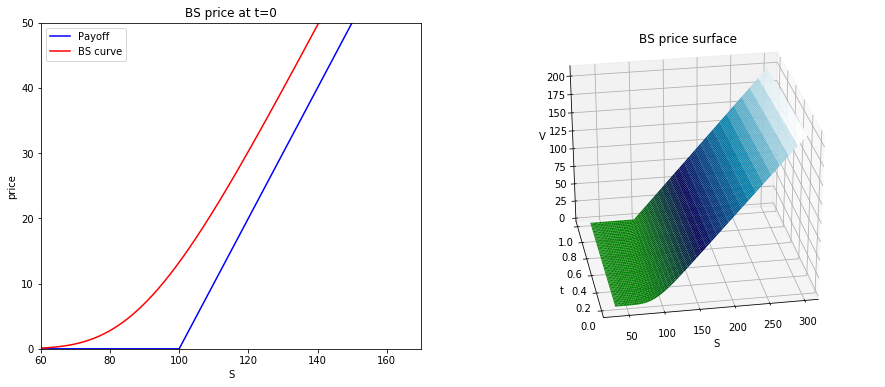

In [14]:
S = np.exp(x)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(S, Payoff, color='blue',label="Payoff")
ax1.plot(S, V[:,0], color='red',label="BS curve")
ax1.set_xlim(60,170); ax1.set_ylim(0,50)
ax1.set_xlabel("S"); ax1.set_ylabel("price")
ax1.legend(loc='upper left'); ax1.set_title("BS price at t=0")

X, Y = np.meshgrid(T, S)
ax2.plot_surface(Y, X, V, cmap=cm.ocean)
ax2.set_title("BS price surface")
ax2.set_xlabel("S"); ax2.set_ylabel("t"); ax2.set_zlabel("V")
ax2.view_init(30, -100) # this function rotates the 3d plot
plt.show()

In the class BS_pricer more methods are implemented. Let us have a look:

In [15]:
from functions.Parameters import Option_param
from functions.Processes import Diffusion_process
from functions.BS_pricer import BS_pricer

# Creates the object with the parameters of the option
opt_param = Option_param(S0=100, K=100, T=1, exercise="European", payoff="call" )

# Creates the object with the parameters of the process
diff_param = Diffusion_process(r=0.1, sig=0.2)

# Creates the object of the pricer
BS = BS_pricer(opt_param, diff_param)

ModuleNotFoundError: No module named 'functions.cython.cython_functions'

By default the method PDE_price uses the LU solver. Let us compare the execution times of three implementations:
- splu
- Thomas: I wrote a wrapper of a LAPACK function.  [code](./functions/Solvers.py)
- spsolve
- SOR: I wrote the SOR solver in cython, such that it would be easily integrated with the python code. However it is still very slow. [Cython code](./functions/cython/cython_functions.pyx)
  From this cell it is also not possible to modify the SOR parameters (if you want to modify it, you need to enter the *BS.PDE_price* method in [BS_pricer class](./functions/BS_pricer.py) ). 
  
The SOR and Thomas algorithms are explained in the notebook **A1** and the code optimization for the SOR algorithm is the topic of the notebook **A2**. Further comparisons (with cython and C code) are in the notebook A2.

In [ ]:
print("Price: {0:.6f} Time: {1:.6f}".format(*BS.PDE_price((5000,4000), Time=True, solver="splu")))
print("Price: {0:.6f} Time: {1:.6f}".format(*BS.PDE_price((5000,4000), Time=True, solver="Thomas")))
print("Price: {0:.6f} Time: {1:.6f}".format(*BS.PDE_price((5000,4000), Time=True, solver="spsolve")))
print("Price: {0:.6f} Time: {1:.6f}".format(*BS.PDE_price((5000,4000), Time=True, solver="SOR")))

**Thomas and SPLU are super fast!!!**


A put option can be priced by changing the terminal and boudary conditions. You can read the implementation code inside "BS_pricer".

In [ ]:
put_param = Option_param(S0=100, K=100, T=1, exercise="European", payoff="put" )
# Creates the object of the put pricer
put = BS_pricer(put_param, diff_param)
print("price: ", put.PDE_price((5000,4000)))
put.plot(axis=[50,140,0,50])

### References

[1] Björk Tomas (2009). Arbitrage theory in continuous time, Oxford Financial Press. 

[2] Wilmott Paul (1994). Option pricing: Mathematical models and computation. Oxford Financial Press.